In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import h5py

from pprint import pprint
from torch.utils.data import DataLoader
import shutil
import numpy as np
import re 

from PIL import Image
from tqdm import tqdm
from urllib.request import urlretrieve
import json

from pytransform3d.transform_manager import TransformManager


## Dataloader class

In [2]:

class RoboCupDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None):

        assert mode in {"train", "valid", "test", "two_sequence", "three_sequence"}

        self.root = root
        self.mode = mode
        self.transform = transform

        self.files_directory = self.root

        self.filenames = self._read_split()  # read train/valid/test splits
        
        self.classes = {0:0,  40:1, 88:2, 112:3, 136:4, 184:5, 208:6, 232:7}
        
        #Saving Camera Matrix K and its inverse
        if self.mode ==  "train" or self.mode == "valid": 
            filename = self.filenames[0]
        elif self.mode == "two_sequence" or self.mode == "three_sequence":
            filename = self.filenames[0][0]
        print ("filename ", filename)
        file_path = os.path.join(self.files_directory, filename)

        with h5py.File(file_path, 'r') as data:
            transformation_matrix = json.loads(np.array(data['camera_pose']).item().decode()) 
            
        self.K = np.array(transformation_matrix['cam_K']).reshape(3,3)
        self.Kinv= np.linalg.inv(self.K)

        

    def __len__(self):
        return len(self.filenames)

    
    @staticmethod
    def _give_rotation_translation(old_transformation_matrix,
                                 new_transformation_matrix):
        R = np.array(old_transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(old_transformation_matrix['cam_t_w2c']).reshape(3,1)
        old_pose = np.hstack((R,T))
        old_pose = np.vstack((old_pose,[0., 0., 0., 1.]))
        
        R = np.array(new_transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(new_transformation_matrix['cam_t_w2c']).reshape(3,1)
        new_pose = np.hstack((R,T))
        new_pose = np.vstack((new_pose,[0., 0., 0., 1.]))
        
        tm = TransformManager()
        tm.add_transform("world", "old_pose", old_pose)
        tm.add_transform("world", "new_pose", new_pose)
        old2new = tm.get_transform("old_pose", "new_pose")
        R = old2new[:3,:3]
        T = old2new[:3,3].reshape(3,1)
        return R, T
    
    def __getitem__(self, idx):

        if self.mode == "train" or self.mode == "valid": 
            filename = self.filenames[idx]
            file_path = os.path.join(self.files_directory, filename)

            with h5py.File(file_path, 'r') as data: 
                image = np.array(data['colors'])
                mask = np.array(data['class_segmaps'])


            #trimap = np.array(Image.open(mask_path))
            mask = self._preprocess_mask(mask)

            sample = dict(image=image, mask=mask)
            if self.transform is not None:
                sample = self.transform(**sample)
        elif self.mode == "two_sequence" or self.mode == "three_sequence":
            #For sequence
            # send all the n images
            # only last frame maske
            # all the poses 
            seq_filenames = self.filenames[idx]
            
            images = []
            maskes = []
            depths = []
            transformation_matrices = []
            for filename in seq_filenames:
                file_path = os.path.join(self.files_directory, filename)

                with h5py.File(file_path, 'r') as data: 
                    images.append(np.array(data['colors']))
                    mask = np.array(data['class_segmaps'])
                    depths.append(np.array(data['depth']))
                    transformation_matrices.append(json.loads(np.array(data['camera_pose']).item().decode()))

                #trimap = np.array(Image.open(mask_path))
                maskes.append( self._preprocess_mask(mask))

            sample = dict(image=images, mask=maskes, transformation_matrix=transformation_matrices)
            
            if self.mode == "two_sequence":
                rotation_old_to_new_camera_frame, \
                translation_old_to_new_camera_frame = self._give_rotation_translation(transformation_matrices[0], 
                                                                                  transformation_matrices[1])
                sample = dict(image0 = images[0],
                              depth0 = depths[0],
                              image1 = images[1], 
                              mask0 = maskes[0], 
                              mask1 = maskes[1], 
                              rotation_old_to_new_camera_frame = rotation_old_to_new_camera_frame,
                              translation_old_to_new_camera_frame = translation_old_to_new_camera_frame)
            elif self.mode == "three_sequence":
                raise NotImplemented

        else:
            raise NotImplementedError("check mode variable while instantiating")

        return sample

    @staticmethod
    def _preprocess_mask(mask):
        classes = {0:0,  40:1, 88:2, 112:3, 136:4, 184:5, 208:6, 232:7}
        mask = mask.astype(np.float32)
        #Remove this and do it in before loading data and save as h5p5
        for c in classes:
            mask[mask==c] = classes[c]

        return mask
    
    
    
    
    def _read_split(self):
        def _atoi(text):
            return int(text) if text.isdigit() else text

        def _natural_keys(text):
            '''
            alist.sort(key=natural_keys) sorts in human order
            http://nedbatchelder.com/blog/200712/human_sorting.html
            (See Toothy's implementation in the comments)
            '''
            return [ _atoi(c) for c in  text.split('.') ]

        
        filenames = [f for f in os.listdir(self.files_directory) if os.path.isfile(os.path.join(self.files_directory, f))]
        
        if self.mode == "train":  # 90% for train
            filenames = [x for i, x in enumerate(filenames) if i % 10 != 0]
        elif self.mode == "valid":  # 10% for validation
            filenames = [x for i, x in enumerate(filenames) if i % 10 == 0]
        elif self.mode == "three_sequence": 
            #Sorting files as per the numbering
            # Assumption that files are numbered '0.hdf5', '1.hdf5', '10.hdf5', '
            # Assumption there is 3 images in sequnce starting from 0 
            filenames.sort(key=_natural_keys)
            
            filenames = [[filenames[i+n] for n in range(3)] 
                         for i, x in enumerate(filenames) if i % 3 == 0]
        elif self.mode == "two_sequence": 
            #Sorting files as per the numbering
            # Assumption that files are numbered '0.hdf5', '1.hdf5', '10.hdf5', '
            filenames.sort(key=_natural_keys)
            
            # 3 camera poses can be divided into 2 frames each
            # for example 1 - 2- 3 images
            # can be divided in to [1,2] and [2,3] sequence
            filenames = [[filenames[i+j+n] for n in range(2)] 
                         for i, x in enumerate(filenames) if i % 3 == 0
                         for j in range(2)] 
                        
            print( filenames)
        return filenames


class SequenceRoboCupDataset(RoboCupDataset):
    def __getitem__(self, *args, **kwargs):

        sample = super().__getitem__(*args, **kwargs)
        
        
        # resize images
        image0 = np.array(Image.fromarray(sample["image0"]).resize((512, 512), Image.LINEAR))
        image1 = np.array(Image.fromarray(sample["image1"]).resize((512, 512), Image.LINEAR))
        mask0 = np.array(Image.fromarray(sample["mask0"]).resize((512, 512), Image.NEAREST))
        mask1 = np.array(Image.fromarray(sample["mask1"]).resize((512, 512), Image.NEAREST))


        # convert to other format HWC -> CHW
        sample["image0"] = np.moveaxis(image0, -1, 0)
        sample["image1"] = np.moveaxis(image1, -1, 0)
        sample["mask0"] = np.expand_dims(mask0, 0)
        sample["mask1"] = np.expand_dims(mask1, 0)

        return sample


In [3]:
root = '../learning_blenerproc/images_pose_robocup/'

train_dataset = SequenceRoboCupDataset(root, "two_sequence")


[['0000.hdf5', '0001.hdf5'], ['0001.hdf5', '0002.hdf5'], ['0003.hdf5', '0004.hdf5'], ['0004.hdf5', '0005.hdf5'], ['0006.hdf5', '0007.hdf5'], ['0007.hdf5', '0008.hdf5'], ['0009.hdf5', '0010.hdf5'], ['0010.hdf5', '0011.hdf5'], ['0012.hdf5', '0013.hdf5'], ['0013.hdf5', '0014.hdf5'], ['0015.hdf5', '0016.hdf5'], ['0016.hdf5', '0017.hdf5'], ['0018.hdf5', '0019.hdf5'], ['0019.hdf5', '0020.hdf5'], ['0021.hdf5', '0022.hdf5'], ['0022.hdf5', '0023.hdf5'], ['0024.hdf5', '0025.hdf5'], ['0025.hdf5', '0026.hdf5'], ['0027.hdf5', '0028.hdf5'], ['0028.hdf5', '0029.hdf5'], ['0030.hdf5', '0031.hdf5'], ['0031.hdf5', '0032.hdf5'], ['0033.hdf5', '0034.hdf5'], ['0034.hdf5', '0035.hdf5'], ['0036.hdf5', '0037.hdf5'], ['0037.hdf5', '0038.hdf5'], ['0039.hdf5', '0040.hdf5'], ['0040.hdf5', '0041.hdf5'], ['0042.hdf5', '0043.hdf5'], ['0043.hdf5', '0044.hdf5'], ['0045.hdf5', '0046.hdf5'], ['0046.hdf5', '0047.hdf5'], ['0048.hdf5', '0049.hdf5'], ['0049.hdf5', '0050.hdf5'], ['0051.hdf5', '0052.hdf5'], ['0052.hdf5', '0053

## Debug

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=int(16/2))
batch = next(iter(train_dataloader))
batch['depth0'].shape

torch.Size([10, 512, 512])

### Old code 

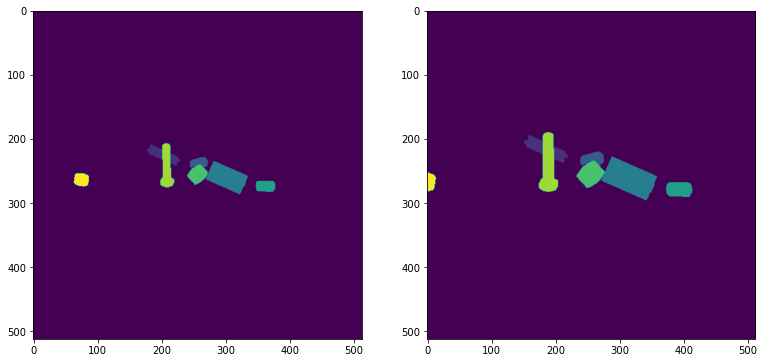

In [5]:
depth = batch['depth0'][0].detach().numpy()

mask0 = batch['mask0'][0].detach().numpy()
mask0 = np.transpose(mask0,(1,2,0))

mask1 = batch['mask1'][0].detach().numpy()
mask1 = np.transpose(mask1,(1,2,0))

plt.figure(figsize=(20, 10))
ax = plt.subplot(1, 3, 1)
plt.imshow(mask0)
ax = plt.subplot(1, 3, 2)
plt.imshow(mask1)

plt.show()

In [6]:
import skimage

 new pt shape  (3, 262144)
dst  (512, 512, 1)
old_seg  (512, 512, 1)


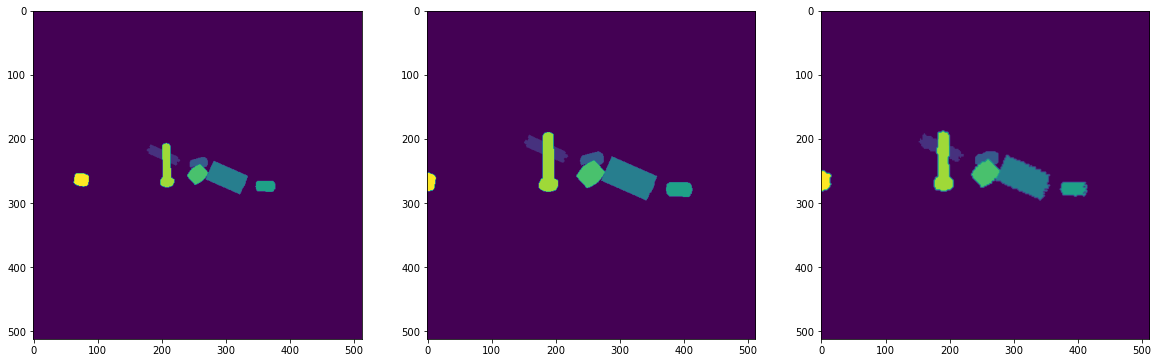

In [7]:
K = train_dataset.K
Kinv = train_dataset.Kinv

R = batch['rotation_old_to_new_camera_frame'][0].detach().numpy()
T = batch['translation_old_to_new_camera_frame'][0].detach().numpy()


def give_rotation_translation(old_pose, new_pose):
    tm = TransformManager()
    tm.add_transform("world", "old_pose", old_pose)
    tm.add_transform("world", "new_pose", new_pose)
    new2old = tm.get_transform("old_pose", "new_pose")
    return new2old

height, width = depth.shape

K = np.array(K).reshape(3,3)



x = np.arange(height)
y = np.arange(width)

# full coorindate arrays
xx, yy = np.meshgrid(x, y, indexing='ij')
xx = xx.reshape(height*width)
yy = yy.reshape(height*width)

## Stacking to make the matrix 3 x points
pts = np.vstack((xx, yy, np.ones_like(xx)))

ravelFilledDepth = depth.reshape(height*width)

new_pt = K.dot(R).dot(Kinv).dot(pts) + K.dot(T/ravelFilledDepth)
new_pt = new_pt / new_pt[2][:]
new_pt = new_pt.round().astype(int)
new_pt = new_pt.clip(min=0, max=511)

print (" new pt shape ", new_pt.shape)
dst = np.zeros_like(mask0)
print ("dst ", dst.shape )
print ("old_seg ", mask0.shape )

dst[new_pt[0], new_pt[1], :] = mask0[xx, yy, : ]

#np.take(mask0, 0, new_pt[0,:].reshape(512,512,1).astype(int))

for i in range(mask0.shape[-1]):
    temp_dst = skimage.measure.block_reduce(dst[:,:,i], (2,2), np.max)
    dst[:,:,i] = skimage.transform.resize(temp_dst, (height,width),
                       anti_aliasing=False)
    #dst[:,:,i] = skimage.transform.rescale( temp_dst, 2)
    
dst = dst.round().astype(int)



plt.figure(figsize=(20, 10))
ax = plt.subplot(1, 3, 1)
plt.imshow(mask0)
ax = plt.subplot(1, 3, 2)
plt.imshow(mask1)
ax = plt.subplot(1, 3, 3)
plt.imshow(dst)
plt.show()


### Torch code

In [8]:
flattened_depth = torch.flatten(batch['depth0'], start_dim=1)
flattened_depth = torch.unsqueeze(flattened_depth, dim=1)
print ("flateneded Depth ", flattened_depth.shape)
T = batch['translation_old_to_new_camera_frame']
print ("Translatio : ", T.shape,)
print (T[0])
R = batch['rotation_old_to_new_camera_frame'].double()
print ("Rotation : ", R.shape,  R[0])

flateneded Depth  torch.Size([10, 1, 262144])
Translatio :  torch.Size([10, 3, 1])
tensor([[-0.0021],
        [-0.0004],
        [-0.2940]], dtype=torch.float64)
Rotation :  torch.Size([10, 3, 3]) tensor([[ 1.0000e+00,  0.0000e+00,  4.1633e-17],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
        [-1.3878e-17,  0.0000e+00,  1.0000e+00]], dtype=torch.float64)


In [9]:
height = 512
width = 512
x = torch.arange(height)
y = torch.arange(width)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
grid_x = torch.flatten(grid_x, start_dim=0)
grid_y = torch.flatten(grid_y, start_dim=0)

## Stacking to make the matrix 3 x points
pts = torch.vstack((grid_x, grid_y, torch.ones_like(grid_y)))
print ("index pts shape ", pts.shape)


index pts shape  torch.Size([3, 262144])


In [10]:
K = torch.tensor(train_dataset.K)
Kinv = torch.tensor(train_dataset.Kinv)

Kinv = Kinv.float()
K = K.float()
R = R.float()
pts = pts.float()
flattened_depth = flattened_depth.float()
T = T.float()

In [11]:
transposed_index = torch.matmul(torch.matmul(torch.matmul(K, R), Kinv), pts) + torch.matmul(K,torch.div(T, flattened_depth))
print (transposed_index.shape)

torch.Size([10, 3, 262144])


In [12]:

small_g = transposed_index[:,2,:]
small_g = small_g.unsqueeze(1)
small_g.shape

new_pts_tensor = torch.div(transposed_index, small_g)
new_pts_tensor

tensor([[[-28.1299, -28.0710, -28.0122,  ..., 677.0511, 676.8479, 676.6448],
         [-27.6879, -26.5222, -25.3570,  ..., 676.4387, 677.8959, 679.3516],
         [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000]],

        [[-55.5123, -55.4833, -55.4542,  ..., 600.0919, 600.0559, 600.0199],
         [-56.8226, -55.5739, -54.3255,  ..., 595.3301, 596.6410, 597.9517],
         [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000]],

        [[-72.7520, -72.8328, -72.9137,  ..., 701.7663, 701.9138, 702.0614],
         [-72.5949, -71.3956, -70.1957,  ..., 698.6725, 700.5802, 702.4893],
         [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000]],

        ...,

        [[-49.6120, -49.6635, -49.7151,  ..., 635.8815, 635.9628, 636.0439],
         [-48.6072, -47.4605, -46.3135,  ..., 635.3769, 636.9415, 638.5067],
         [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000]],

        [[-80.3039, -80.3525, -80.4012,  ..., 658.6559

In [13]:

new_pts_tensor_clamped = torch.clamp(new_pts_tensor, min=0, max=511).type(torch.LongTensor) # imagesize is 512 ,  1 less than 512
new_pts_tensor_clamped

tensor([[[  0,   0,   0,  ..., 511, 511, 511],
         [  0,   0,   0,  ..., 511, 511, 511],
         [  1,   1,   1,  ...,   1,   1,   1]],

        [[  0,   0,   0,  ..., 511, 511, 511],
         [  0,   0,   0,  ..., 511, 511, 511],
         [  1,   1,   1,  ...,   1,   1,   1]],

        [[  0,   0,   0,  ..., 511, 511, 511],
         [  0,   0,   0,  ..., 511, 511, 511],
         [  1,   1,   1,  ...,   1,   1,   1]],

        ...,

        [[  0,   0,   0,  ..., 511, 511, 511],
         [  0,   0,   0,  ..., 511, 511, 511],
         [  1,   1,   1,  ...,   1,   1,   1]],

        [[  0,   0,   0,  ..., 511, 511, 511],
         [  0,   0,   0,  ..., 511, 511, 511],
         [  1,   1,   1,  ...,   1,   1,   1]],

        [[  0,   0,   0,  ..., 511, 511, 511],
         [  0,   0,   0,  ..., 511, 511, 511],
         [  1,   1,   1,  ...,   1,   1,   1]]])

In [14]:
new_pts_tensor_clamped.shape

torch.Size([10, 3, 262144])

In [15]:
batch['mask0'].shape

torch.Size([10, 1, 512, 512])

In [16]:
new_pts_tensor_clamped[:,0,:].shape

torch.Size([10, 262144])

In [17]:
xdst = torch.zeros_like(batch['mask0'])
print (xdst.shape)

torch.Size([10, 1, 512, 512])


In [18]:
grid_x.shape

torch.Size([262144])

In [19]:
for p in new_pts_tensor_clamped:
    print (p[0].shape)

torch.Size([262144])
torch.Size([262144])
torch.Size([262144])
torch.Size([262144])
torch.Size([262144])
torch.Size([262144])
torch.Size([262144])
torch.Size([262144])
torch.Size([262144])
torch.Size([262144])


torch.Size([3, 262144]) torch.Size([10, 1, 512, 512]) torch.Size([10, 1, 512, 512])
torch.Size([10, 1, 512, 512]) tensor([0., 1., 2., 3., 4., 5., 6., 7.])
torch.Size([512, 512]) tensor([0., 1., 2., 3., 4., 5., 6., 7.])
torch.Size([3, 262144]) torch.Size([10, 1, 512, 512]) torch.Size([10, 1, 512, 512])
torch.Size([10, 1, 512, 512]) tensor([0., 1., 2., 3., 4., 5., 6., 7.])
torch.Size([512, 512]) tensor([0., 1., 2., 3., 4., 5., 6., 7.])
torch.Size([3, 262144]) torch.Size([10, 1, 512, 512]) torch.Size([10, 1, 512, 512])
torch.Size([10, 1, 512, 512]) tensor([0., 1., 2., 3., 4., 5., 6., 7.])
torch.Size([512, 512]) tensor([0., 1., 2., 3., 4., 5., 6., 7.])
torch.Size([3, 262144]) torch.Size([10, 1, 512, 512]) torch.Size([10, 1, 512, 512])
torch.Size([10, 1, 512, 512]) tensor([0., 1., 2., 3., 4., 5., 6., 7.])
torch.Size([512, 512]) tensor([0., 1., 2., 3., 4., 5., 6., 7.])
torch.Size([3, 262144]) torch.Size([10, 1, 512, 512]) torch.Size([10, 1, 512, 512])
torch.Size([10, 1, 512, 512]) tensor([0.

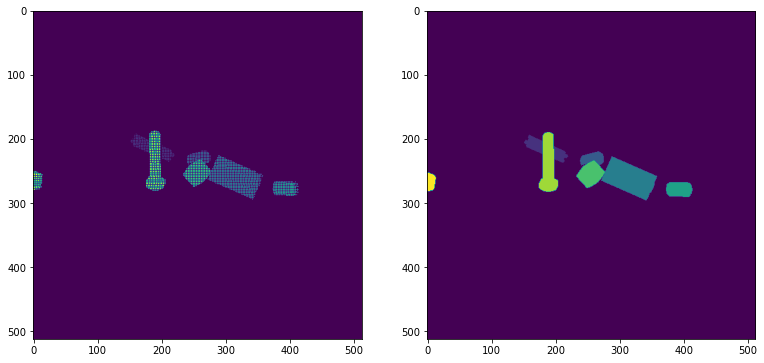

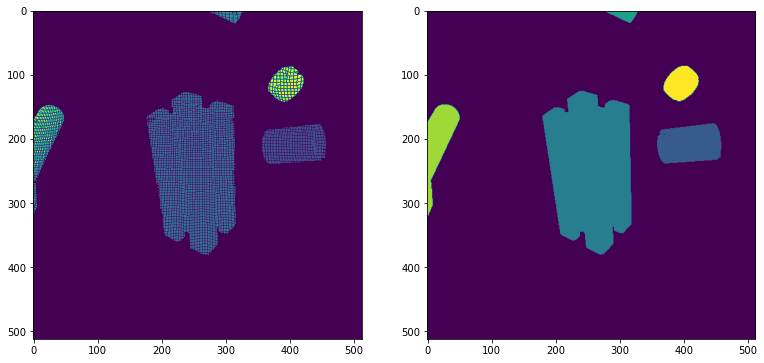

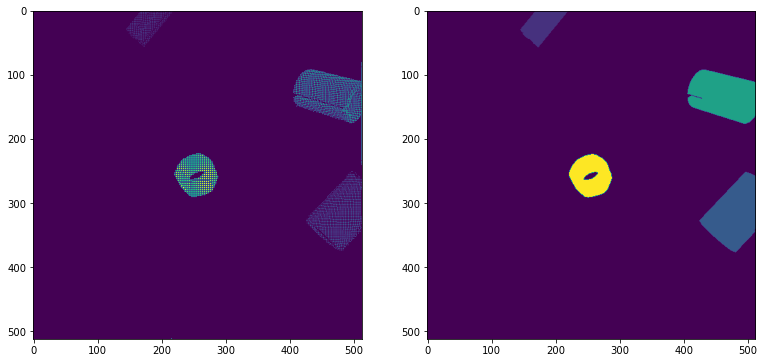

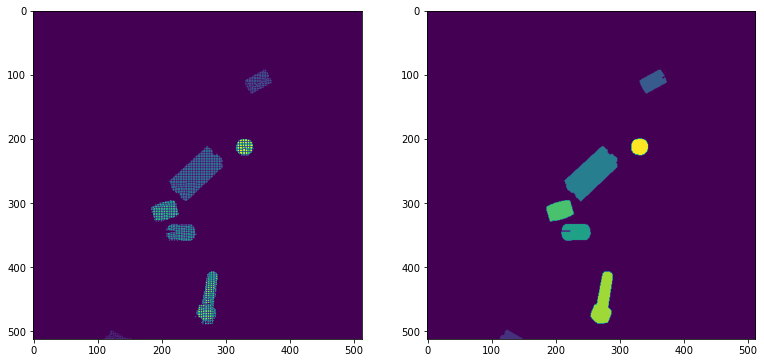

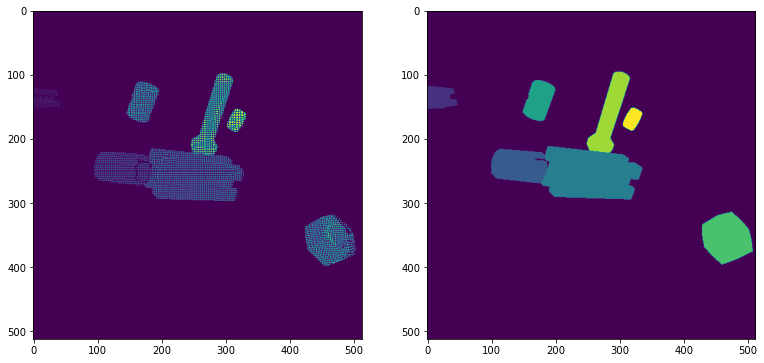

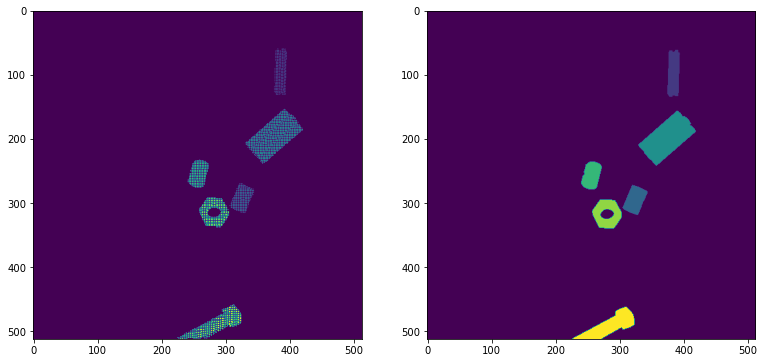

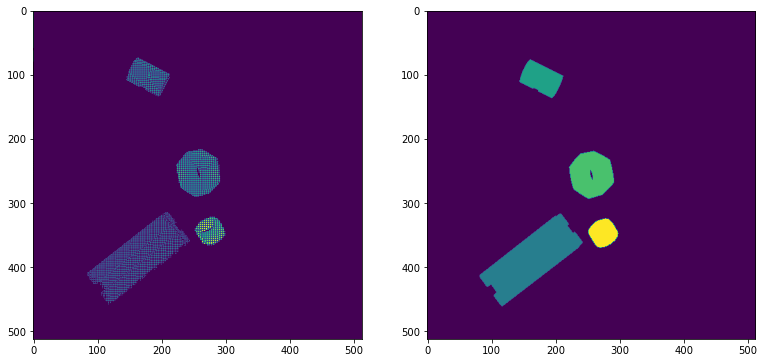

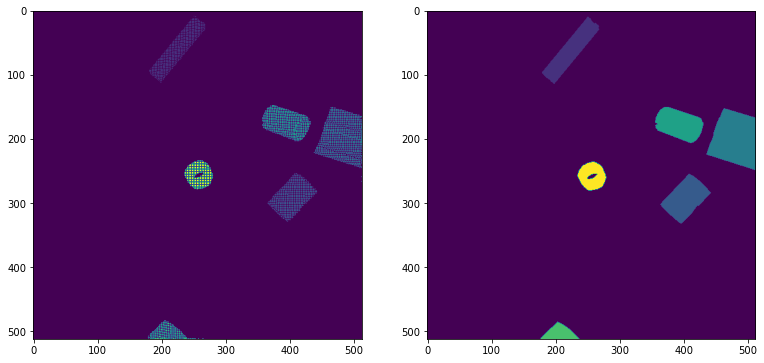

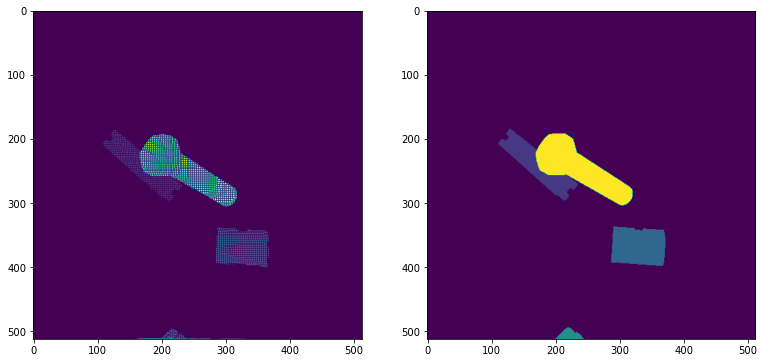

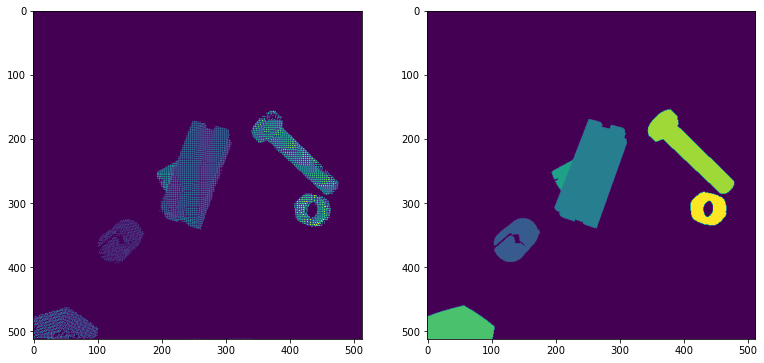

In [23]:
for i,p in enumerate(new_pts_tensor_clamped):
    print (p.shape, xdst.shape, batch['mask0'].shape)
    xdst[i,0,p[0],p[1]] = batch['mask0'][i,0,grid_x, grid_y]
#xdst[:,:,new_pts_tensor_clamped[:,0,:].squeeze(), new_pts_tensor_clamped[:,1,:].squeeze()] = batch['mask0'][:,:,grid_x, grid_y]

    print(xdst.shape, torch.unique(xdst))
    x = xdst[i].reshape(512,512)
    x = x.type(torch.LongTensor)
    print(x.shape, torch.unique(xdst))

    plt.figure(figsize=(20, 10))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(x)
    ax = plt.subplot(1, 3, 2)

    mask1 = batch['mask1'][i].detach().numpy()
    mask1 = np.transpose(mask1,(1,2,0))
    plt.imshow(mask1)


In [29]:
xdst = xdst.type(torch.FloatTensor)
torch.unique(xdst)
m = torch.nn.MaxPool2d(2)
small_dst = m(xdst)
print (xdst.shape, small_dst.shape)

torch.Size([10, 1, 512, 512]) torch.Size([10, 1, 256, 256])


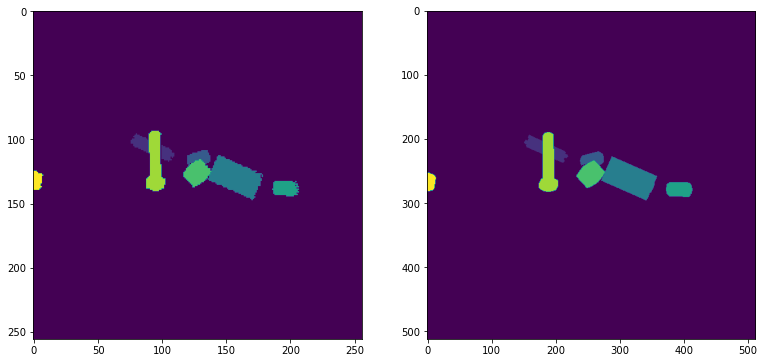

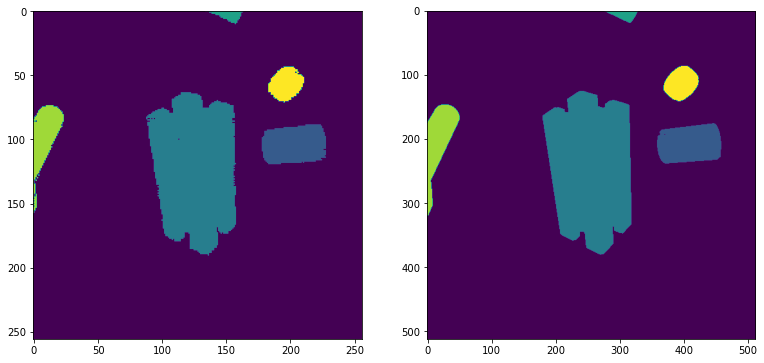

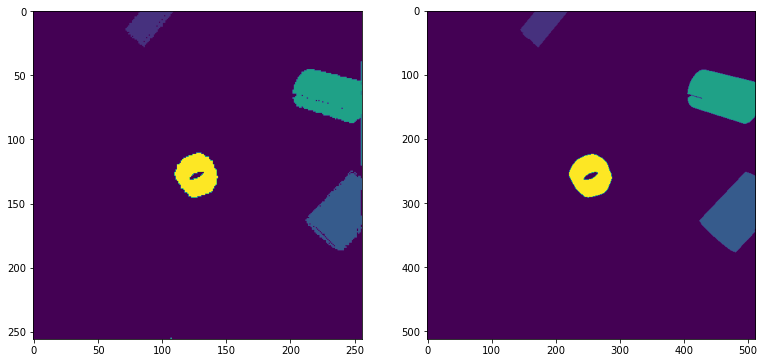

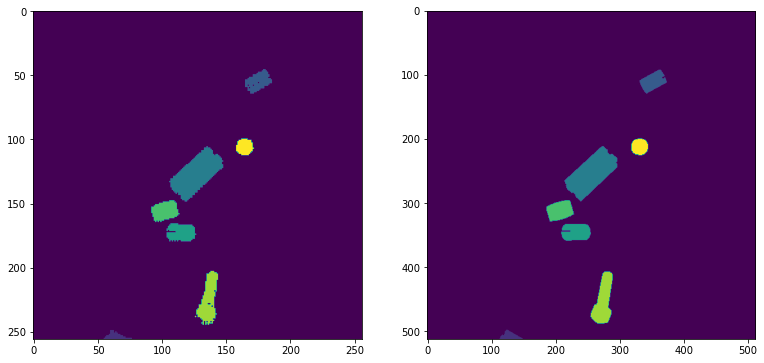

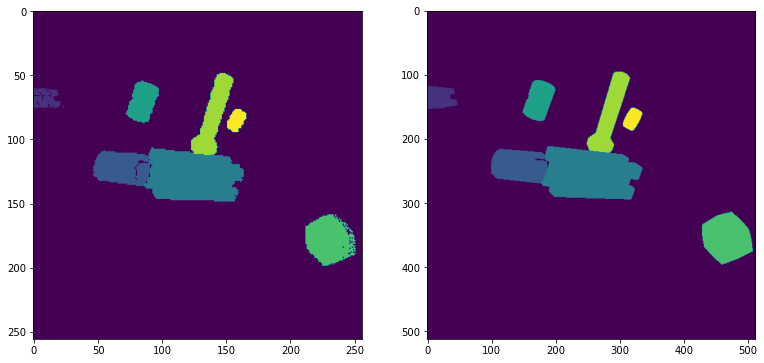

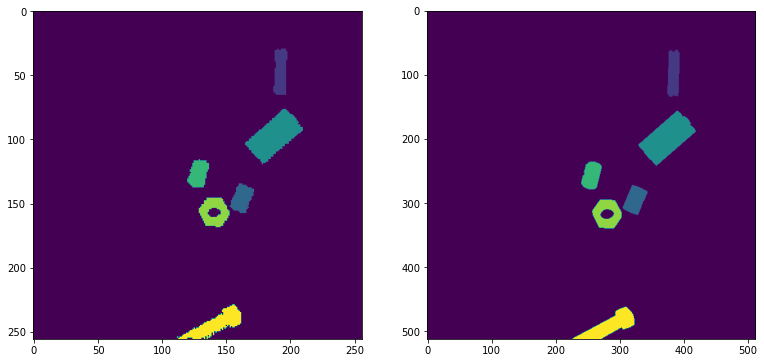

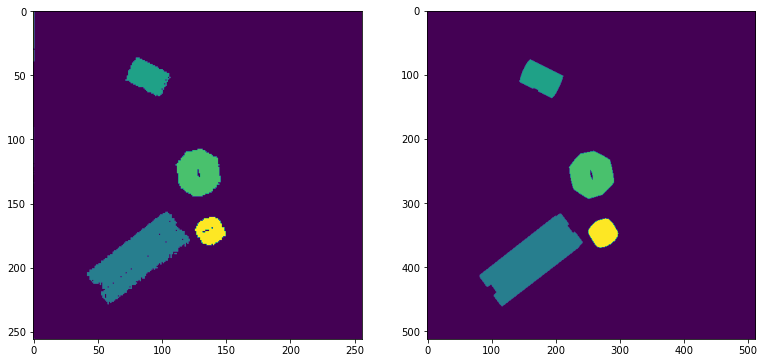

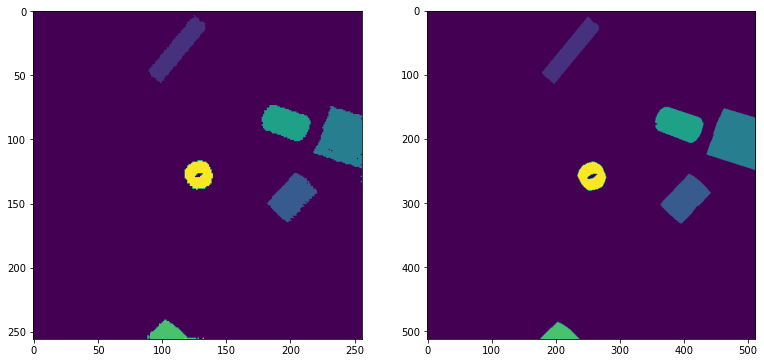

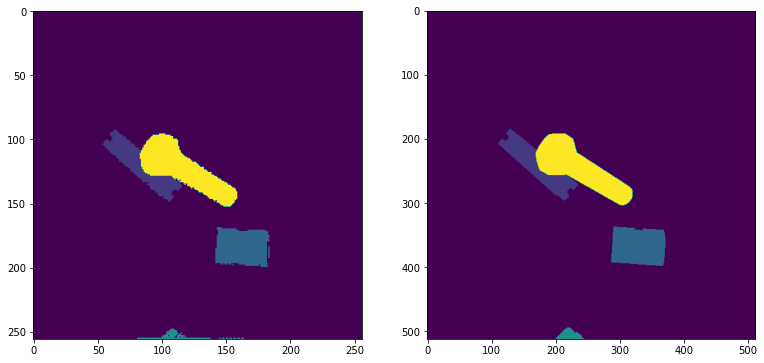

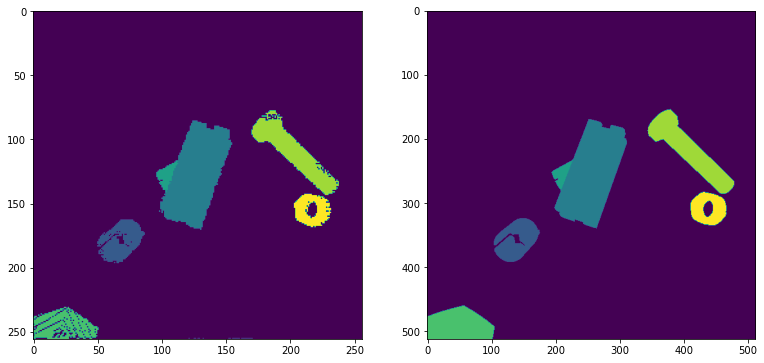

In [30]:
for i,p in enumerate(new_pts_tensor_clamped):
    x = small_dst[i].detach().numpy()
    x = np.transpose(x,(1,2,0))
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(x)
    ax = plt.subplot(1, 3, 2)

    mask1 = batch['mask1'][i].detach().numpy()
    mask1 = np.transpose(mask1,(1,2,0))
    plt.imshow(mask1)


#### USing interpoalte

In [33]:
from torch.nn.functional import interpolate

y = interpolate(small_dst, scale_factor=2 )
y.shape

torch.Size([10, 1, 512, 512])

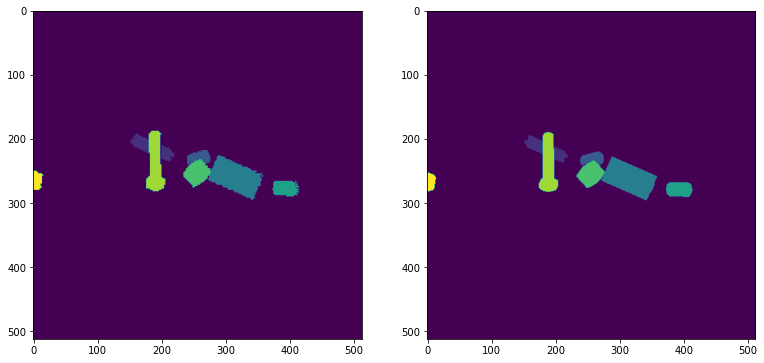

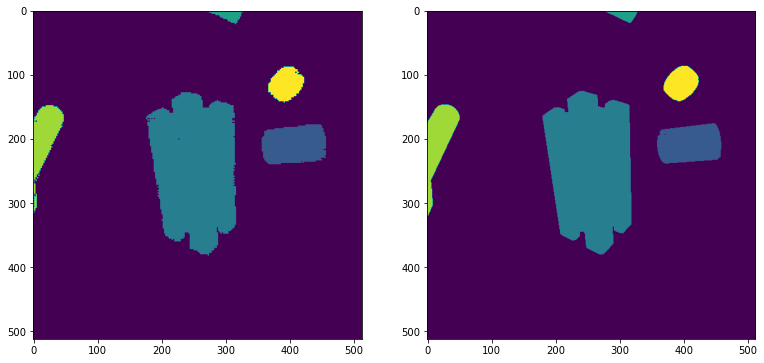

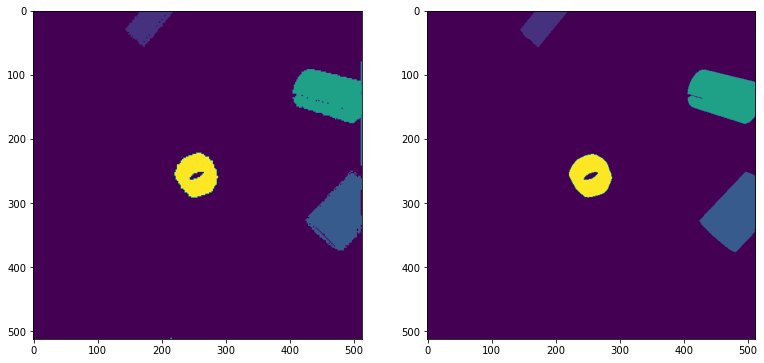

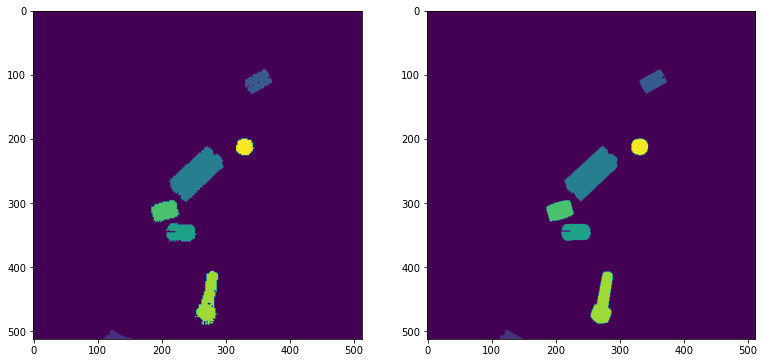

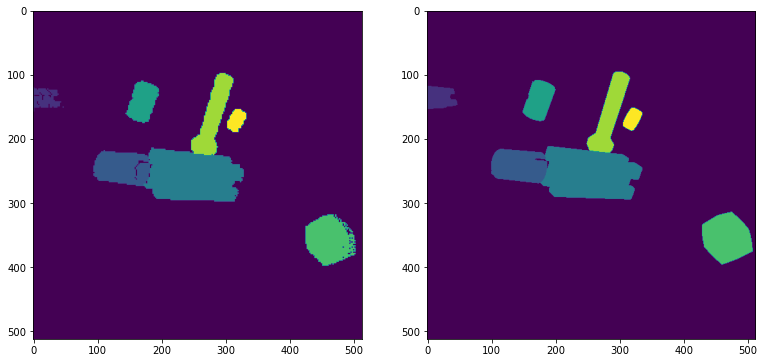

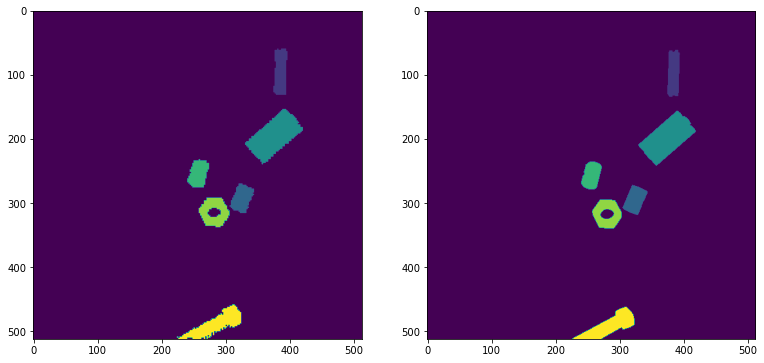

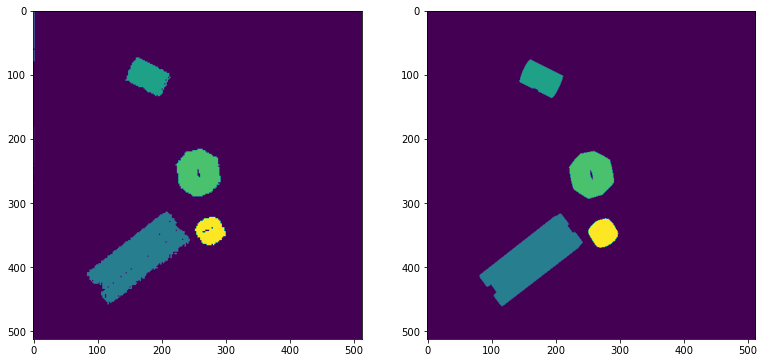

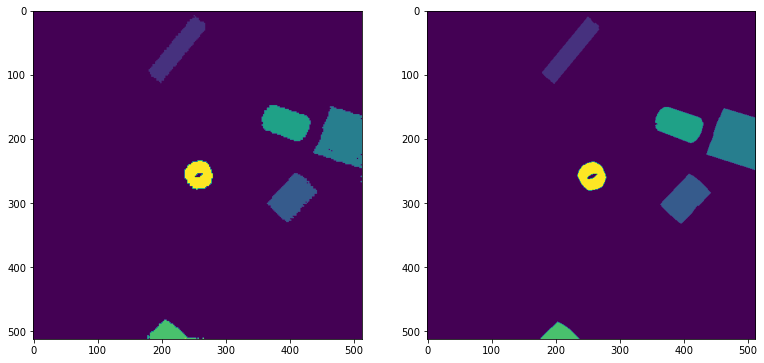

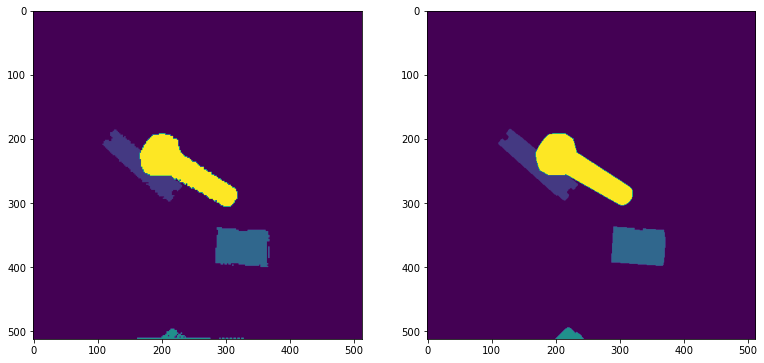

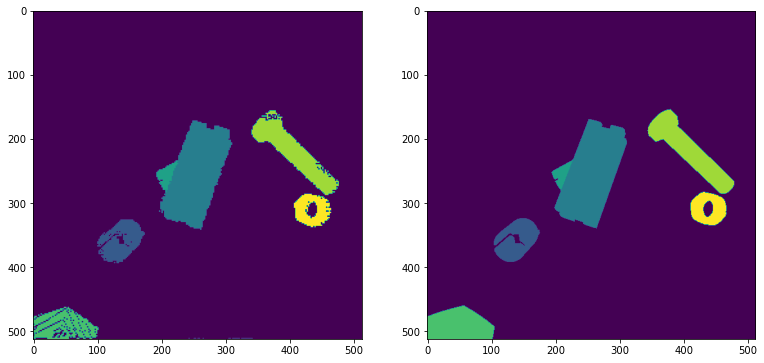

In [32]:
for i,p in enumerate(new_pts_tensor_clamped):
    x = y[i].detach().numpy()
    x = np.transpose(x,(1,2,0))
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(x)
    ax = plt.subplot(1, 3, 2)

    mask1 = batch['mask1'][i].detach().numpy()
    mask1 = np.transpose(mask1,(1,2,0))
    plt.imshow(mask1)


------

torch.Size([1, 1, 262144]) torch.Size([1, 1, 262144])
tensor([0.])


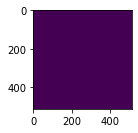

In [63]:
channel = 0
dimension = 2
only_first_index_for_gather = new_pts_tensor_clamped[:,channel,:].unsqueeze(0)

flattened_mask = torch.flatten(batch['mask0'], start_dim=2)
print (only_first_index_for_gather.shape, flattened_mask.shape)


transposed_mask = torch.gather(flattened_mask, dimension, only_first_index_for_gather)
print (transposed_mask.unique())
tmask = transposed_mask[0].reshape(512,512)

ax = plt.subplot(1, 3, 3)
plt.imshow(tmask)


### Tensor with nclasses output 

In [34]:
batch['image0'].shape

torch.Size([10, 3, 512, 512])

In [35]:
ximage = torch.zeros_like(batch['image0'])


In [41]:
new_pts_tensor_clamped[:,0,:].shape

torch.Size([10, 262144])

In [42]:
ximage[:,:,new_pts_tensor_clamped[:,0,:],new_pts_tensor_clamped[:,1,:]] = batch['image0'][:,:,grid_x, grid_y]

RuntimeError: shape mismatch: value tensor of shape [10, 3, 262144] cannot be broadcast to indexing result of shape [10, 3, 10, 262144]

torch.Size([3, 262144]) torch.Size([10, 3, 512, 512]) torch.Size([10, 3, 512, 512])
torch.Size([3, 262144]) torch.Size([10, 3, 512, 512]) torch.Size([10, 3, 512, 512])
torch.Size([3, 262144]) torch.Size([10, 3, 512, 512]) torch.Size([10, 3, 512, 512])
torch.Size([3, 262144]) torch.Size([10, 3, 512, 512]) torch.Size([10, 3, 512, 512])
torch.Size([3, 262144]) torch.Size([10, 3, 512, 512]) torch.Size([10, 3, 512, 512])
torch.Size([3, 262144]) torch.Size([10, 3, 512, 512]) torch.Size([10, 3, 512, 512])
torch.Size([3, 262144]) torch.Size([10, 3, 512, 512]) torch.Size([10, 3, 512, 512])
torch.Size([3, 262144]) torch.Size([10, 3, 512, 512]) torch.Size([10, 3, 512, 512])
torch.Size([3, 262144]) torch.Size([10, 3, 512, 512]) torch.Size([10, 3, 512, 512])
torch.Size([3, 262144]) torch.Size([10, 3, 512, 512]) torch.Size([10, 3, 512, 512])


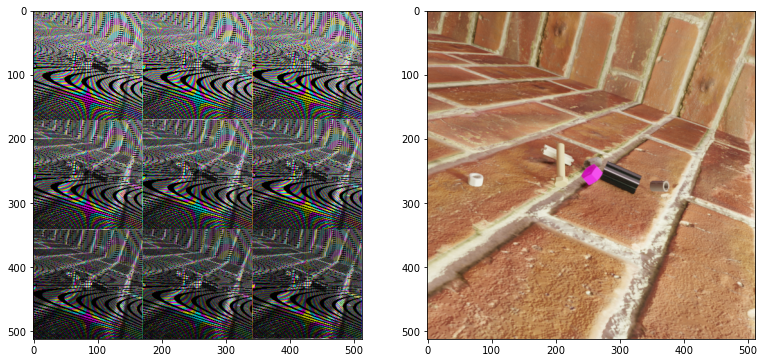

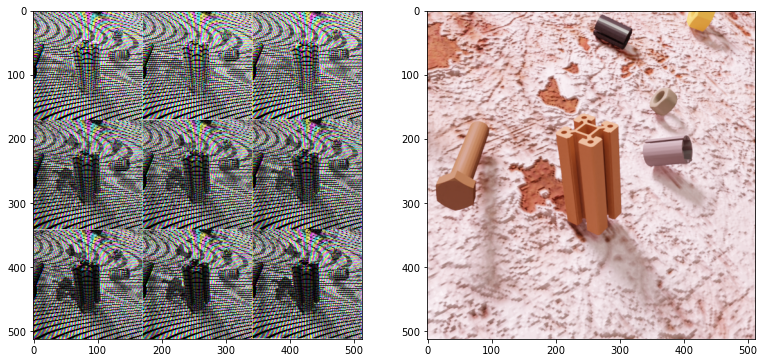

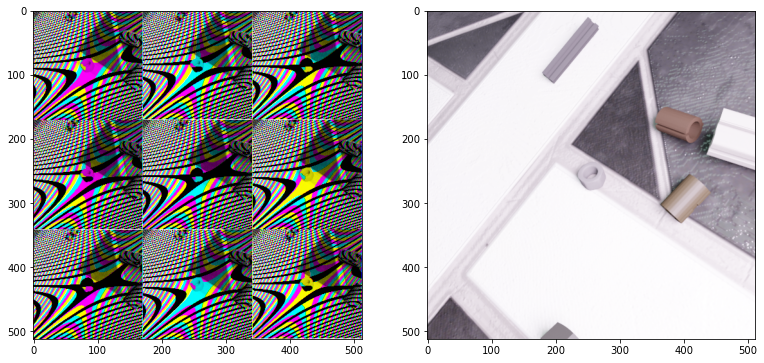

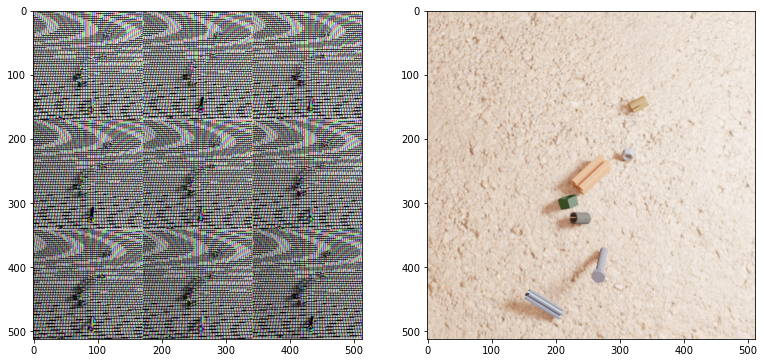

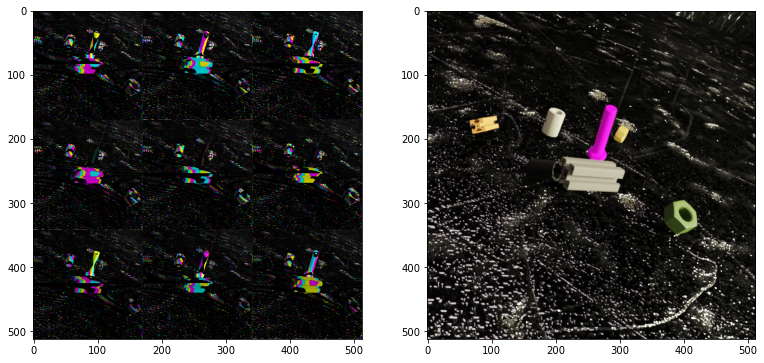

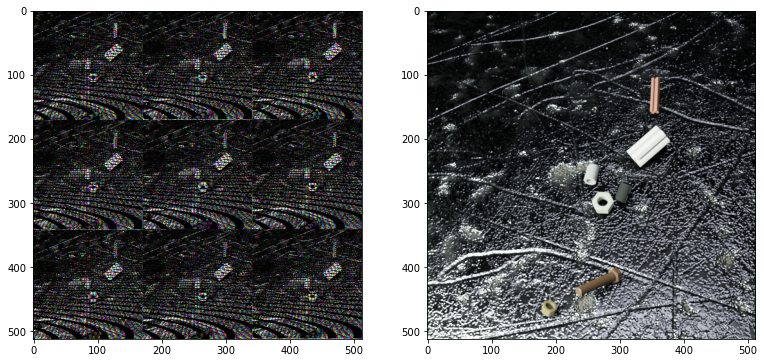

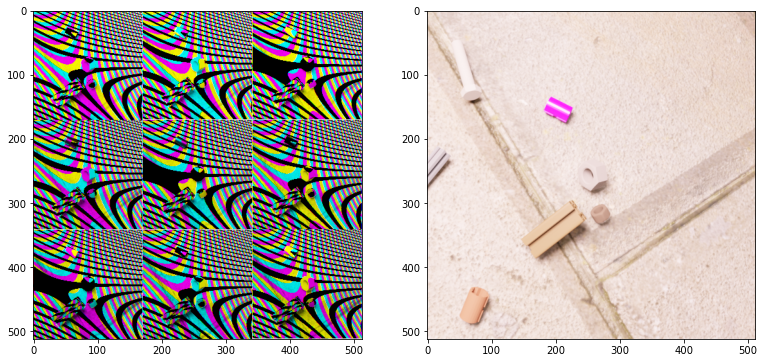

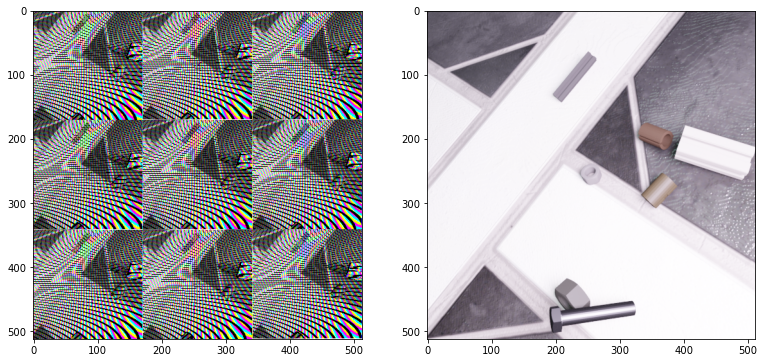

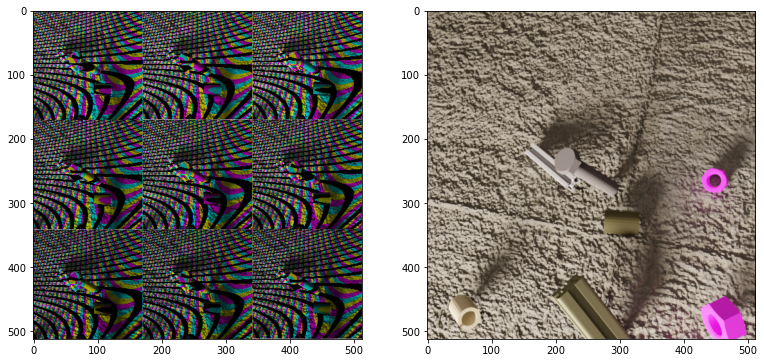

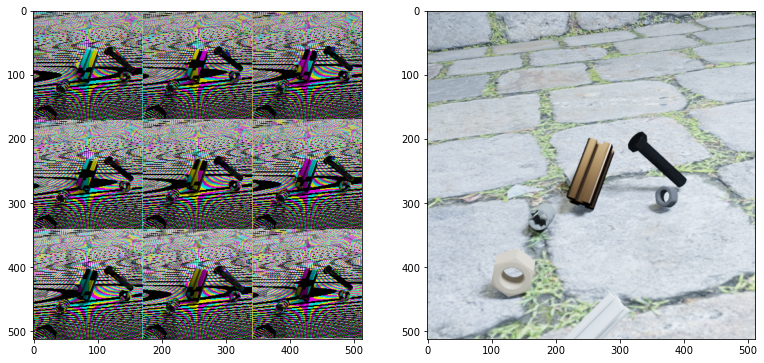

In [37]:
for i,p in enumerate(new_pts_tensor_clamped):
    print (p.shape, ximage.shape, batch['image0'].shape)
    for j in range(3):
        ximage[i,j,p[0],p[1]] = batch['image0'][i,j,grid_x, grid_y]
    x = ximage[i].reshape(512,512,3)
    
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(x)
    ax = plt.subplot(1, 3, 2)

    mask1 = batch['image0'][i].detach().numpy()
    mask1 = np.transpose(mask1,(1,2,0))
    plt.imshow(mask1)

------

### Learning Gather

In [67]:
height = 2
width = 4
x = torch.arange(height)
y = torch.arange(width)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
#grid_x = torch.flatten(grid_x, start_dim=0)
#grid_y = torch.flatten(grid_y, start_dim=0)

## Stacking to make the matrix 3 x points
index = torch.vstack((grid_x, grid_y, torch.ones_like(grid_y)))
#index = index.unsqueeze(0)
#index = index.repeat(1, 3, 1)

print ("Index shape : ", index.shape)
print (index)

image = torch.randn(1, 3, 4, 4)
#image = image.unflatten(1, [3, 3])
#image = image.unflatten(1, [3, 3])
#image = torch.flatten(image, start_dim=2)
print ("image shape ", image.shape)

Index shape :  torch.Size([6, 4])
tensor([[0, 0, 0, 0],
        [1, 1, 1, 1],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [1, 1, 1, 1],
        [1, 1, 1, 1]])
image shape  torch.Size([1, 3, 4, 4])


In [55]:
channel = 0
dimension = 1
only_first_index_for_gather = index[:,channel,:].unsqueeze(0)

print (image.shape, only_first_index_for_gather.shape)
transposed_mask = torch.gather(image, dim=2, index=only_first_index_for_gather)



torch.Size([1, 3, 16]) torch.Size([1, 1, 16])


In [47]:
t = torch.ones(16).type(torch.LongTensor)
t = t.reshape(1,1,16)
t

tensor([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]])

In [53]:
print (image.shape, t.shape)
torch.gather(image, dim=2, index=t)

torch.Size([1, 3, 16]) torch.Size([1, 1, 16])


tensor([[[-0.0488, -0.0488, -0.0488, -0.0488, -0.0488, -0.0488, -0.0488,
          -0.0488, -0.0488, -0.0488, -0.0488, -0.0488, -0.0488, -0.0488,
          -0.0488, -0.0488]]])

Take an image
Flatten the image 
and select the values

In [77]:
a = torch.tensor([
                    [
                        [
                            [1, 2],
                            [3,4]
                        ]
                    ]
                 ])
a.shape

torch.Size([1, 1, 2, 2])

In [71]:
a = torch.flatten(a, start_dim=2)
a.shape

torch.Size([1, 1, 4])

In [74]:
t = torch.tensor([[[2, 3, 1, 0]]])
t.shape

torch.Size([1, 1, 4])

In [76]:
torch.gather(a, dim=2, index=t)

tensor([[[3, 4, 2, 1]]])

Take the image dont flatten it because the index has to be modiffied


In [78]:
a = torch.tensor([[[[1, 2],
                    [3,4]
                    ]]])
a.shape

torch.Size([1, 1, 2, 2])

In [79]:
a[0,0,1,1]

tensor(4)

In [81]:
xx = [1,1,0,0]
yy = [0,1,1,0]
a[:,:,xx,yy]

tensor([[[3, 4, 2, 1]]])